## 6.2 랭그래프 활용

### 6.2.1 루프 구현하기

In [1]:
%%capture --no-stderr
%pip install -U langgraph
%pip install -U langchain-openai
%pip install -U python-dotenv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from dotenv import load_dotenv
import os

# .env 파일에서 환경 변수 로드
load_dotenv("/content/.env")

True

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# 실습에서 사용할 그래프의 상태값 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 실습에서 사용할 그래프 정의
graph_builder = StateGraph(State)

In [5]:
from langchain_openai import ChatOpenAI

# 오픈AI 클라이언트 정의
llm = ChatOpenAI(model="gpt-4o-mini")

# 오픈AI를 호출하여 응답을 받아 온 뒤, 상태값에 저장하여 반환하는 챗봇 함수 정의
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# 챗봇 노드 정의
graph_builder.add_node("chatbot", chatbot)

In [6]:
from langgraph.graph import StateGraph, START, END
# 진입지점
graph_builder.add_edge(START, "chatbot")
# 종료지점
graph_builder.add_edge("chatbot", END)

In [7]:
graph = graph_builder.compile()

In [8]:
while True:
    # 사용자의 질의 입력받음
    user_input = input("User: ")
    print("User:", user_input)

    # 사용자가 quit 혹은 exit 혹은 q를 입력했다면 루프 종료
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    # 사용자의 입력을 그래프에 입력하여 정의된 흐름 실행
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


User: 너는 누구야?
User: 너는 누구야?
Assistant: 저는 여러분의 질문에 답하고 정보를 제공하기 위해 설계된 인공지능 언어 모델입니다. 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!
User: ㅂ
User: ㅂ
Assistant: 안녕하세요! 무엇을 도와드릴까요?
User: q
User: q
Goodbye!


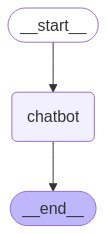

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### 6.2.2 조건문 구현하기

In [10]:
%%capture --no-stderr
%pip install -U tavily-python
%pip install -U langchain_community

In [11]:
from dotenv import load_dotenv

# .env 파일에서 환경 변수 로드
load_dotenv("/content/.env")

True

In [12]:
from langchain_community.tools.tavily_search import TavilySearchResults

# Tavily검색 엔진을 도구로 정의
tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("내일 대한민국 서울의 날씨는?")

[{'title': '서울 실시간 날씨 정보 | 서울 공식 관광정보 웹사이트',
  'url': 'https://korean.visitseoul.net/weather',
  'content': '전체보기메뉴 열기버튼\n검색영역 닫기버튼\n검색 영역 열기  검색어 삭제 검색실행\n검색순위\n전체보기메뉴 열기버튼\nvisitseoul.net\n검색\n검색영역  닫기 검색실행\n검색순위\n나의 찜한 목록\n나의 찜한 목록\n나의 찜하기 툴팁 버튼\n찜하기는 관심 있는 여행 정보를 저장하여 서울의 주요 지역별로 탐색할 수 있는 기능입니다.\n나의 찜한 목록 바로가기\nvisitseoul.net\n전체보기메뉴 닫기버튼\n서울의 날씨\n> 여행정보> 서울의 날씨\n서울의 날씨\n3일 예보\n3일 예보 : 날짜, 날씨, 최저/최고기온(℃), 강수확률 날짜오늘 : 2025-02-25내일 : 2025-02-26모레 : 2025-02-27날씨구름많음맑음맑음최저/최고기온(℃)-2℃ / 7℃-2℃ / 6℃-1℃ / 11℃강수확률20% / 20%10% / 0%-\n대기오염 상세\n대기오염 상세 : 날짜, 미세먼지, 초미세먼지 날짜오늘예보내일예보모레예보미세먼지 (PM10) 보통 보통 보통초미세먼지 (PM2.5) 보통 나쁨 나쁨 [...] 주간예보\n주간예보 : 날짜, 날씨, 최저/최고기온(℃)      날짜2025-02-252025-02-262025-02-272025-02-282025-03-01날씨구름많음맑음맑음흐림흐림최저/최고기온(℃)-2℃ / 7℃-2℃ / 6℃-1℃ / 11℃3℃ / 13℃5℃ / 12℃\n제공 : 케이웨더(Kweather)\nSTO 서울관광재단 SEOUL TOURISM ORGANIZATION SEOUL MY SOUL\n개인정보처리방침 공지사항\n운영\n월~금, 오전 9시~오후 6시 staff@visitseoul.net\n문의\n관광불편처리센터 일반 관광 문의 1330\nVisit Seoul 모바일 앱\nApp Store Google Play\n비짓서울 공식채널'

In [13]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


# 그래프 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]


# 그래프 정의
graph_builder = StateGraph(State)

# 오픈AI 클라이언트 정의
llm = ChatOpenAI(model="gpt-4o-mini")
# 오픈AI 클라이언트에 Tavily 검색 엔진 도구를 할당
llm_with_tools = llm.bind_tools(tools)

# 챗봇 함수 정의
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 그래프에 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

In [14]:
import json

from langchain_core.messages import ToolMessage


# 도구 노드로 사용될 클래스
class BasicToolNode:

    # 도구 노드에서 사용될 초기 파라미터 정의
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    # 도구 노드가 호출되었을때의 행동 정의
    def __call__(self, inputs: dict):
        # 입력된 상태의 가장 마지막 메세지 획득
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        # 메세지의 tool_calls 에 도구호출을 위한 값들이 존재한다면 이를 활용해 도구 호출
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # 도구 호출의 결과물을 ToolMessage로 정의하여 출력값에 저장
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result, ensure_ascii=False),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        # 출력값을 상태값 형식에 맞춰 반환
        return {"messages": outputs}


# 도구 노드 정의
tool_node = BasicToolNode(tools=[tool])
# 도구 노드 그래프에 추가
graph_builder.add_node("tools", tool_node)

In [15]:
from typing import Literal


# 도구노드 호출 여부를 결정하는 함수 정의
def route_tools(
        state: State,
) -> Literal["tools", "__end__"]:
    # 상태값의 가장 최근 메세지를 정의
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # 가장 최근 메세지가 tool_calls 속성을 포함하고 있다면 tools 노드를 아니라면 종료지점을 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# 챗봇 노드에 조건부 엣지를 정의
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", "__end__": "__end__"},
)

In [16]:
# 도구 노드와 챗봇 노드 연결
graph_builder.add_edge("tools", "chatbot")
# 진입지점으로 챗봇 노드 지정
graph_builder.add_edge(START, "chatbot")

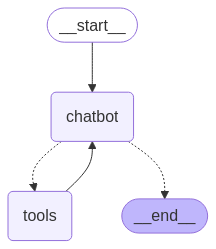

In [17]:
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### 6.2.3 스트리밍

In [18]:
from langchain_core.messages import BaseMessage

while True:
    # 사용자의 질문을 입력받습니다
    user_input = input("User: ")
    print("User:", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    # 업데이트된 내용을 확인할 수 있는 그래프 스트리밍을 정의합니다.
    events = graph.stream(input={"messages": [("user", user_input)]}, stream_mode="updates")

    # 그래프 이벤트 내의 메세지를 출력합니다.
    for event in events:
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)


User: 25년 4월5일 서울의 날씨 알려줘
User: 25년 4월5일 서울의 날씨 알려줘
Assistant: 
Assistant: [{"title": "4월 2025의 날씨 서울: 온도 및 기후 - Climate-Data.org", "url": "https://ko.climate-data.org/%EC%95%84%EC%8B%9C%EC%95%84/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD/%EC%84%9C%EC%9A%B8-1931/r/4%EC%9B%94-4/", "content": "4월의 서울 날씨 ; 온도 4월, 10.7°C ; 온도 4월 최대. 16.3°C ; 온도 4월 분. 5.6°C ; 강수량 / 강수량 4월, 73mm", "score": 0.83678174}, {"title": "[오늘의 날씨] 2025년 4월 5일 - 조선일보", "url": "https://www.chosun.com/national/transport-environment/2025/04/05/4WK4T5QWVVFVPIZXV66L6YV5O4/", "content": "[오늘의 날씨] 2025년 4월 5일 2025년 4월 5일(토) 신문구독|中文|English|日本語 [오늘의 날씨] 2025년 4월 5일 조선일보 4일 오전 10시 59분, 문형배 헌법재판소장 권한대행을 비롯한 8명의 헌법재판관이 헌법재판소 대심판정 안으로 들어섰다. 4일 헌법재판소가 윤석열 대통령 탄핵을 인용하자 손현보 부산세계로교회 목사의 주도로 서울 여의도와 전국 각지에서 대규모 탄핵 반대 집... 尹 운명 가른 헌법 재판관 8인은 누구 헌법재판소는 4일 재판관 8명의 만장일치로 윤석열 전 대통령의 탄핵소추안을 인용했다. 尹 운명 가른 헌법 재판관 8인은 누구 헌법재판소는 4일 재판관 8명의 만장일치로 윤석열 전 대통령의 탄핵소추안을 인용했다. 尹 운명 가른 헌법 재판관 8인은 누구 尹 운명 가른 헌법 재판관 8인은 누구 칼럼 정치 일반 국제 일반 사회 일반 경제 일반 스포츠 일반 연예 일

### 6.2.4 상태 저장하기

In [19]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [20]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

# 미리 빌드된 도구노드
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# 미리 빌드된 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# 체크포인터를 지정하여 그래프를 컴파일
graph = graph_builder.compile(checkpointer=memory)

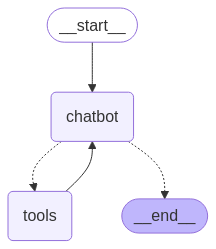

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
config = {"configurable": {"thread_id": "1"}}

In [23]:
user_input = "안녕! 내 이름은 오해원이야."

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

안녕! 내 이름은 오해원이야.
================================== Ai Message ==================================

안녕하세요, 오해원님! 반가워요. 어떻게 도와드릴까요?


In [24]:
user_input = "내 이름을 기억하니?"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

내 이름을 기억하니?
================================== Ai Message ==================================

네, 오해원님! 당신의 이름을 기억하고 있습니다. 어떻게 도와드릴까요?


In [25]:
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

내 이름을 기억하니?
================================== Ai Message ==================================

죄송하지만, 당신의 이름이나 개인 정보를 기억하지 못합니다. 대화가 끝나면 모든 정보가 초기화되기 때문입니다. 어떻게 도와드릴까요?


In [26]:
snapshot = graph.get_state(config)
print(snapshot)

StateSnapshot(values={'messages': [HumanMessage(content='안녕! 내 이름은 오해원이야.', additional_kwargs={}, response_metadata={}, id='9d23eb9a-0142-46cc-8e7d-e61ebe9fb765'), AIMessage(content='안녕하세요, 오해원님! 반가워요. 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 90, 'total_tokens': 112, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BImqDGOhmmqdJjNdeNRn9cgc28gBk', 'finish_reason': 'stop', 'logprobs': None}, id='run-55c746d3-418e-41d3-b5a7-5886c99cc791-0', usage_metadata={'input_tokens': 90, 'output_tokens': 22, 'total_tokens': 112, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='내 이름을 기억하

### 6.2.5 루프 개입하기

In [27]:
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"],
)

In [28]:
user_input = "지금 서울 날씨 어때?"
config = {"configurable": {"thread_id": "2"}}
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

지금 서울 날씨 어때?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_zlr5LoIBmvseV324lYHOK0SG)
 Call ID: call_zlr5LoIBmvseV324lYHOK0SG
  Args:
    query: 현재 서울 날씨


In [29]:
snapshot = graph.get_state(config)
print(snapshot.next)

('tools',)


In [30]:
from langchain_core.messages import AIMessage

# 최근 메세지
existing_message = snapshot.values["messages"][-1]
# 최근 메세지의 id
existing_message_id = existing_message.tool_calls[0]["id"]

# 강제할 응답 정의
answer = (
    "서울의 날씨는 매우 맑아요."
)

# 강제할 응답을 포함한 메세지 상태 정의
new_messages = [
    ToolMessage(content=answer, tool_call_id=existing_message_id),
    AIMessage(content=answer),
]
# 그래프 상태를 새로 작성한 메세지 상태로 변경
graph.update_state(
    config,
    {"messages": new_messages},
)


{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f011bf6-27d3-6147-8005-fed4b5b488aa'}}

In [31]:
print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])



Last 2 messages;
[ToolMessage(content='서울의 날씨는 매우 맑아요.', id='9614f462-a61c-4e2d-918d-c19a989829cd', tool_call_id='call_zlr5LoIBmvseV324lYHOK0SG'), AIMessage(content='서울의 날씨는 매우 맑아요.', additional_kwargs={}, response_metadata={}, id='595bc727-43ca-49ec-bdeb-15583437ff9d')]


In [32]:
existing_message = snapshot.values["messages"][-3]
print(existing_message)

content='죄송하지만, 당신의 이름이나 개인 정보를 기억하지 못합니다. 대화가 끝나면 모든 정보가 초기화되기 때문입니다. 어떻게 도와드릴까요?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 86, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BImqt0gYLolfNHWIVff073uEsX44x', 'finish_reason': 'stop', 'logprobs': None} id='run-263c5442-93a2-4846-8607-5ec724376b2b-0' usage_metadata={'input_tokens': 86, 'output_tokens': 40, 'total_tokens': 126, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [33]:
from langchain_core.messages import AIMessage

user_input = "지금 서울 날씨 어때?"
config = {"configurable": {"thread_id": "3"}}
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

지금 서울 날씨 어때?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_WzzcjUDLoPK6vfM7KMp428FO)
 Call ID: call_WzzcjUDLoPK6vfM7KMp428FO
  Args:
    query: Current weather in Seoul


In [34]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "지금 경기도 날씨 어때?"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    id=existing_message.id,
)

graph.update_state(config, {"messages": [new_message]})

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f011bf6-ee93-6004-8002-0b3871a3af94'}}

In [35]:
print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])



Last 2 messages;
[HumanMessage(content='지금 서울 날씨 어때?', additional_kwargs={}, response_metadata={}, id='05f9d54d-30f8-49b0-8314-d623e3d58302'), AIMessage(content='', additional_kwargs={}, response_metadata={}, id='run-0b869f4e-9653-4f4f-ad7d-c4f68357962a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '지금 경기도 날씨 어때?'}, 'id': 'call_WzzcjUDLoPK6vfM7KMp428FO', 'type': 'tool_call'}])]
